---
**License**

 The_distribution_of matter_in_NumCosmo_and_Colossus_libraries
 
 Wen Dec 22 09:40:00 2021\
 Copyright  2021\
 Sandro Dias Pinto Vitenti       <vitenti@uel.br> \
 Mariana Penna-Lima              <pennalima@gmail.com>\
 Ana Caroline Manso de Carvalho  <anacaroljc22@gmail.com>

---
---

 The_distribution_of matter_in_NumCosmo_and_Colossus_libraries\
 Copyright (C) 2021 Sandro Dias Pinto Vitenti <vitenti@uel.br>, Mariana Penna-Lima <pennalima@gmail.com>, Ana   Caroline Manso de Carvalho <anacaroljc22@gmail.com>

 numcosmo is free software: you can redistribute it and/or modify it
 under the terms of the GNU General Public License as published by the
 Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 numcosmo is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 See the GNU General Public License for more details.

 You should have received a copy of the GNU General Public License along
 with this program.  If not, see <http://www.gnu.org/licenses/>.
 
---

## Introduction

In this tutorial we will study some basic functions of the [Large Scale Structure](https://numcosmo.github.io/manual/ch08.html) module of the NumCosmo library, for comparison purposes we will also be using the [Power spectrum](https://bdiemer.bitbucket.io/colossus/cosmology_cosmology.html#module-cosmology.power_spectrum) module from Colossus (COsmology, haLO, and large-Scale StrUcture toolS). First of all we need to import both NumCosmo and NumCosmoMath libraries and the Colossus cosmology module. We also load python libraries necessary to make plots and other miscellaneous tools.

In [1]:
try:
    import gi
    gi.require_version ('NumCosmo', '1.0')
    gi.require_version ('NumCosmoMath', '1.0')
except:
    pass


from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

from colossus.cosmology import cosmology
import colossus.cosmology.power_spectrum as col_ps_obj

import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
#plt.style.use('classic')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['legend.fontsize'] = 12
%matplotlib inline
import time

### The distribution of matter: power spectrum, variance, correlation function

Let's now define the Colossus cosmology and redefine the NumCosmo parameters such that both libraries have the same cosmology.

In [2]:
params = cosmology.cosmologies['planck18']
params['de_model'] = 'w0wa'
params['w0'] = -0.8
params['wa'] = 0.1
params['persistence'] = ''

cosmo_col = cosmology.setCosmology('planck_w0wa', params)

Ncm.cfg_init ()

#cosmo = Nc.HICosmo.new_from_name (Nc.HICosmo, "NcHICosmoDEXcdm{'massnu-length':<0>}")
cosmo = Nc.HICosmo.new_from_name (Nc.HICosmo, "NcHICosmoDECpl{'massnu-length':<0>}")
cosmo.omega_x2omega_k ()
cosmo.param_set_by_name ("H0",        cosmo_col.H0)
cosmo.param_set_by_name ("Omegak",    cosmo_col.Ok(0.0))
cosmo.param_set_by_name ("w0",        cosmo_col.w0)
cosmo.param_set_by_name ("w1",        cosmo_col.wa)
cosmo.param_set_by_name ("Omegab",    cosmo_col.Ob0)
cosmo.param_set_by_name ("Omegac",    (cosmo_col.Om0 - cosmo_col.Ob0))
#cosmo.param_set_by_name ("massnu_0",  Planck13.m_nu.value[2])
cosmo.param_set_by_name ("ENnu",      cosmo_col.Neff - 3.0*cosmo.E2Press_mnu(1.0e10) / (cosmo.E2Omega_g(1.0e10) * (7/8*(4/11)**(4/3))))
cosmo.param_set_by_name ("Tgamma0",   cosmo_col.Tcmb0)

### Power Spectrum

NumCosmo library has an abstract class in [Numcosmo Math](https://numcosmo.github.io/manual/ch02.html) module for power spectrum implementation: the [NcmPowspec](https://numcosmo.github.io/manual/NcmPowspec.html). This class comes with some important functions which we are going to use here as [`ncm_powspec_prepare ()`](https://numcosmo.github.io/manual/NcmPowspec.html#ncm-powspec-prepare)  and [`ncm_powspec_eval ()`](https://numcosmo.github.io/manual/NcmPowspec.html#ncm-powspec-eval) that allow us to get the value of the power spectrum at $(z,k)$, where $z$ is the redshift and $k$ is the wave number. It is not the scope of this notebook to build a Power Spectrum model from scratch, as we can find classes with ready-made linear matter power spectrum models in NumCosmo's large structures module. By default, Colossus evaluates the matter power spectrum using a model for the transfer function, more specifically the [Eisenstein & Hu 1998](http://adsabs.harvard.edu/abs/1998ApJ...496..605E) approximation, thus we are going to use the [NcPowspecMLTransfer](https://numcosmo.github.io/manual/NcPowspecMLTransfer.html), a class that provides a linear matter power spectrum as a function of mode $k$ and redshift $z$ using a transfer function $T(k)$ [NcTransferFunc](https://numcosmo.github.io/manual/NcTransferFunc.html) and the growth function $D(z)$ [NcGrowthFunc](https://numcosmo.github.io/manual/NcGrowthFunc.html),

$$P(k,z) = P_{prim}(k)T(k)^2D(z)^2$$

where $P_{prim}(k)$ is the primordial power spectrum[NcHIPrim](https://numcosmo.github.io/manual/NcHIPrim.html).

In [3]:
reion  = Nc.HIReionCamb.new ()
prim   = Nc.HIPrimPowerLaw.new ()

cosmo.add_submodel (reion)
cosmo.add_submodel (prim)

tf_eh = Nc.TransferFuncEH.new ()
ps_eh  = Nc.PowspecMLTransfer.new (tf_eh)

# Redshift bounds
z_min = 0.0
z_max = 2.0
zdiv  = 0.49999999999

# Mode bounds
k_min = 1.0e-5
k_max = 1.0e3

nk = 2000

ps_eh.set_kmin (k_min)
ps_eh.set_kmax (k_max)
ps_eh.require_zi (z_min)
ps_eh.require_zf (z_max)

prim.param_set_by_name ("n_SA", cosmo_col.ns)
reion.param_set_by_name ("z_re", 9.9999)

# Prepares the power spectrum using the cosmological model.
ps_eh.prepare (cosmo)

old_logAs = prim.param_get_by_name ("ln10e10ASA") 
a         = 2.0 * math.log (cosmo_col.sigma8 / ps_eh.sigma_tophat_R (cosmo, 1.0e-7, 0.0, 8.0 / cosmo.h ()))
new_logAs = old_logAs + a

prim.param_set_by_name ("ln10e10ASA", new_logAs)

cosmo_col = cosmology.getCurrent()


**Some important notes to take regarding the code above:**

Before defining our power spectrum, `ps_eh`, it was necessary to first define the transfer function, the reason is clear when we see the structure of the function [`nc_powspec_ml_transfer_new()`](https://numcosmo.github.io/manual/NcPowspecMLTransfer.html#nc-powspec-ml-transfer-new) in the library documentation where the parameter required by it points for a [NcPowspecMLTransfer](https://numcosmo.github.io/manual/NcPowspecMLTransfer.html) class. We also added two submodels to our cosmology via the [`ncm_model_add_submodel ()`](https://numcosmo.github.io/manual/NcmModel.html#ncm-model-add-submodel) function, one implementing a homogeneous and isotropic reionization model as done in CAMB, [NcHIReionCamb](https://numcosmo.github.io/manual/NcHIReionCamb.html), and the other implementing a power law model for a primordial spectrum, [NcHIPrimPowerLaw](https://numcosmo.github.io/manual/NcHIPrimPowerLaw.html). This process of adding submodels is necessary for the construction of our spectrum, whose $k$ modes are intricately linked to the evolution and consequent composition of our universe.

In [4]:
nc_ps_list = []
col_ps_list = []
k_list = []

for lnk in np.arange (math.log (ps_eh.props.kmin), math.log (ps_eh.props.kmax), math.log (k_max / k_min) / nk):
    k = math.exp (lnk)
    k2 = k * k
    k3 = k2 * k
    
    # Evaluating the power spectrum at (z,k).
    t0 = time.time()
    nc_ps   = ps_eh.eval (cosmo, 0.0, k)
    nc_ps_list.append(nc_ps)
    t1 = time.time()
    
    k_col   = k/(cosmo_col.H0 / 100.0)
    col_ps  = cosmo_col.matterPowerSpectrum (k_col, 0.0)/(cosmo_col.h)**3
    col_ps_list.append(col_ps)    
    t2 = time.time()

    k_list.append(k)
    
nc_ps_array = np.array(nc_ps_list)
col_ps_array = np.array(col_ps_list)

<Figure size 432x288 with 0 Axes>

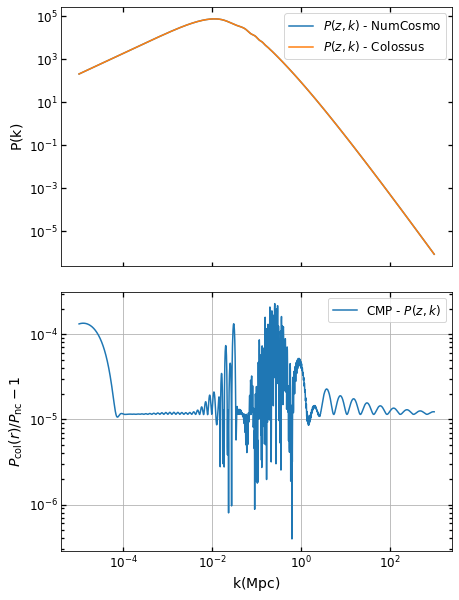

In [5]:
plt.figure()

fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace':0.1}, figsize=(7,10))

axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].plot(k_list, nc_ps_list, '-', lw=1.5, label='$P(z,k)$ - NumCosmo')
axs[0].plot(k_list, col_ps_list, '-', lw=1.5, label='$P(z,k)$ - Colossus')
axs[0].set_ylabel(r'$\mathrm{P(k)}$')
axs[0].tick_params(which='major', direction='in', right=True, top=True, length=4.5, width=1.3, labelsize= 12)
axs[0].tick_params(which='minor', direction='in', right=True, top=True, length=3.0, width=1.3)
axs[0].legend(loc='best')

axs[1].set_yscale ('log')
axs[1].set_ylabel(r'$P_{\mathrm{col}}(r)/P_{\mathrm{nc}} - 1$')
axs[1].plot(k_list, np.abs(col_ps_array/nc_ps_array - 1.0), '-', lw=1.5, label='CMP - $P(z,k)$')
axs[1].set_xlabel(r"$\mathrm{k(Mpc)}$")
axs[1].tick_params(which='major', direction='in', right=True, top=True, length=4.5, width=1.3, labelsize= 12)
axs[1].tick_params(which='minor', direction='in', right=True, top=True, length=3.0, width=1.3)
axs[1].legend(loc='best')
axs[1].grid(True)
plt.savefig("powerspec_fourth.pdf", dpi=300, bbox_inches='tight')

*RunTime*

Next, we also compute the time that each library takes to run the program, this step will be repeated in each subtopic of this notebook for reasons of comparison between the different libraries.

In [6]:
print('#----------------------------------------------------------------------------------')
print('# Power Spectrum, runtime in seconds ')
print('#----------------------------------------------------------------------------------')
print('# - NumCosmo: \t %e ' %(t1 - t0))
print('# - Colossus: \t %e ' %(t2 - t1))

#----------------------------------------------------------------------------------
# Power Spectrum, runtime in seconds 
#----------------------------------------------------------------------------------
# - NumCosmo: 	 7.629395e-06 
# - Colossus: 	 1.096725e-04 


### Variance

The variance in a sphere of radius R applying a top-hat filter at redshift z is defined as

\begin{equation}
\sigma^2_R(z) = \frac{1}{2\pi^2}\int^{k_{max}}_{k_{min}}W^2_{TH}(kR)P(k,z)k^2\ dk
\end{equation}

where, $W_{TH}(t)$ is the top-hat filter in Fourier space,

\begin{equation}
W_{TH}(t) = \frac{3}{t^2}(\sin(t) - t\cos(t)) = \frac{3}{t}j_1(t),
\end{equation}

being $j_1$ the first order spherical Bessel function of the first kind. In NumCosmo library the function [`ncm_powspec_var_tophat_R ()`](https://numcosmo.github.io/manual/NcmPowspec.html#ncm-powspec-var-tophat-R) computes this quantity. Unfortunately Colossus doesn't calculate the variance, instead it calculus the rms variance of the linear density field on a scale R, $\sigma_R(z)$

\begin{equation}
\sigma_R(z) = \sqrt{\sigma^2_R(z)}.
\end{equation}

NumCosmo's function [`ncm_powspec_sigma_tophat_R ()`](https://numcosmo.github.io/manual/NcmPowspec.html#ncm-powspec-sigma-tophat-R) calculate $\sigma_R(z)$. 

To compute our sigma function it is necessary, initially, to define the filter. In the NumCosmo library there is a class to compute filtered power spectrum, the [NcmPowspecFilter](https://numcosmo.github.io/manual/NcmPowspecFilter.html) class in which two types of filters are already defined in the function [`ncm_powspec_filter_new ()`](https://numcosmo.github.io/manual/NcmPowspecFilter.html#ncm-powspec-filter-new), the top-hat fliter and the Gaussian filter.

In our case instead of using the NCM_POWSPEC_FILTER_TYPE_TOPHAT type to the top-hat filter, I've used the function [`ncm_powspec_sigma_tophat_R ()`](https://numcosmo.github.io/manual/NcmPowspec.html#ncm-powspec-sigma-tophat-R), that is already defined in [NcmPowspec](https://numcosmo.github.io/manual/NcmPowspec.html) class.

In [7]:
psf_gauss = Ncm.PowspecFilter.new (ps_eh, Ncm.PowspecFilterType.GAUSS)
psf_gauss.prepare(cosmo)

<Figure size 432x288 with 0 Axes>

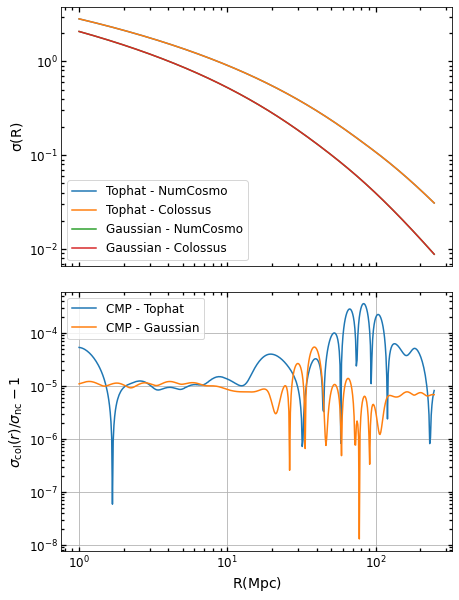

In [8]:
R_list  = 10**np.arange(0,2.4,0.005)
nc_sigma_list = []
nc_sigma_gauss_list = []

for R in R_list:
    s0 = time.time()
    nc_sigma_gauss = psf_gauss.eval_sigma(0.0, R)
    nc_sigma_gauss_list.append(nc_sigma_gauss)
    s1 = time.time()
    
    nc_sigma = ps_eh.sigma_tophat_R(cosmo, 1e-6, 0.0, R)
    nc_sigma_list.append(nc_sigma)
    s2 = time.time()
    
col_sigma = cosmo_col.sigma(R=R_list*cosmo.h(), z=0.0, kmin=1.0e-5, kmax=1.0e3)
s3 = time.time()
# I had to multiplie R by cosmo.h cause in Colossus the distances are given in Mpc/h.
col_sigma_gauss = cosmo_col.sigma(R=R_list*cosmo.h(), z=0.0, filt = 'gaussian', kmin=1.0e-5, kmax=1.0e3)
s4 = time.time()

nc_sigma_gauss_array = np.array(nc_sigma_gauss_list)
nc_sigma_array = np.array(nc_sigma_list)

plt.figure()
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace':0.1}, figsize=(7,10))

axs[0].loglog()
axs[0].plot(R_list, nc_sigma_list, '-', label="Tophat - NumCosmo")
axs[0].plot(R_list, col_sigma, '-', label='Tophat - Colossus')
axs[0].plot(R_list, nc_sigma_gauss_list, '-', label="Gaussian - NumCosmo")
axs[0].plot(R_list, col_sigma_gauss, '-', label='Gaussian - Colossus')
axs[0].set_ylabel(r'$\mathrm{\sigma(R)}$')
axs[0].tick_params(which='major', direction='in', right=True, top=True,  length=4.5, width=1.3, labelsize= 12)
axs[0].tick_params(which='minor', direction='in', right=True, top=True, length=3.0, width=1.3)
axs[0].legend(loc='best')

axs[1].set_yscale ('log')
axs[1].set_ylabel (r'$\sigma_{\mathrm{col}}(r)/ \sigma_{\mathrm{nc}} - 1$')
axs[1].plot(R_list, np.abs(col_sigma/nc_sigma_array - 1.0), '-', label='CMP - Tophat')
axs[1].plot(R_list, np.abs(col_sigma_gauss/nc_sigma_gauss_array - 1.0), '-', label='CMP - Gaussian')
axs[1].set_xlabel(r"$\mathrm{R(Mpc)}$")
axs[1].tick_params(which='major', direction='in', right=True, top=True, length=4.5, width=1.3, labelsize= 12)
axs[1].tick_params(which='minor',direction='in', right=True, top=True, length=3.0, width=1.3)
axs[1].legend(loc='best')
axs[1].grid(True)
plt.savefig("sigma_fourth.pdf", dpi=300, bbox_inches='tight')

*RunTime*

In [9]:
print('#----------------------------------------------------------------------------------')
print('# Sigma Tophat, runtime in seconds ')
print('#----------------------------------------------------------------------------------')
print('# - NumCosmo: \t %e ' %(s2 - s1))
print('# - Colossus: \t %e ' %(s3 - s2))
print('#----------------------------------------------------------------------------------')
print('# Sigma Gauss, runtime in seconds ')
print('#----------------------------------------------------------------------------------')
print('# - NumCosmo: \t %e ' %(s1 - s0))
print('# - Colossus: \t %e ' %(s4 - s3))

#----------------------------------------------------------------------------------
# Sigma Tophat, runtime in seconds 
#----------------------------------------------------------------------------------
# - NumCosmo: 	 1.641512e-03 
# - Colossus: 	 6.399937e-01 
#----------------------------------------------------------------------------------
# Sigma Gauss, runtime in seconds 
#----------------------------------------------------------------------------------
# - NumCosmo: 	 2.145767e-06 
# - Colossus: 	 3.577013e-01 


### Correlation Function

The function [`ncm_powspec_corr3d_eval_xi ()`](https://numcosmo.github.io/manual/NcmPowspecCorr3d.html#ncm-powspec-corr3d-eval-xi) computes the spatial function in configuration space at redshift $z$ and position $r$,

\begin{equation}
\xi(r,z) = \frac{1}{2\pi^2}\int^{k_{max}}_{k_{min}}P(k,z)j_0(kr)k^2\ dk,
\end{equation}

where, $j_0(t)$ is the zero order spherical Bessel function of the first kind.

<Figure size 432x288 with 0 Axes>

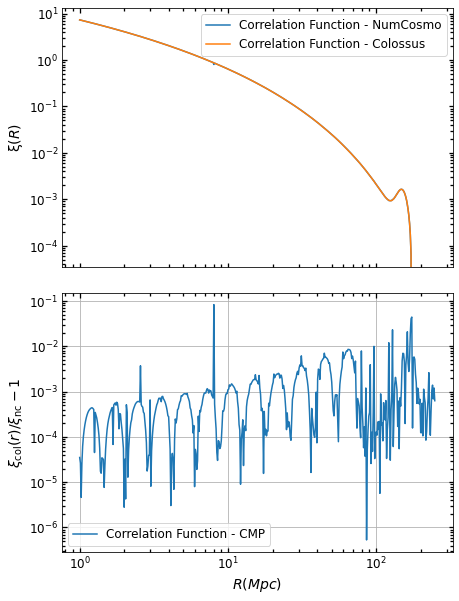

In [11]:
nc_corr3d_list = []
c0 = time.time()
for R in R_list:    
    nc_corr3d = ps_eh.corr3d(cosmo, 1e-3, 0.0, R)
    nc_corr3d_list.append(nc_corr3d)
c1 = time.time()

col_corr3d = cosmo_col.correlationFunction(R_list*cosmo.h(), z=0.0)
c2 = time.time()
nc_corr3d_array = np.array(nc_corr3d_list)

plt.figure()

fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace':0.1}, figsize=(7,10))

axs[0].loglog()
axs[0].set_ylabel(r'$\mathrm{\xi}(R)$')
axs[0].plot(R_list, nc_corr3d_list, '-', label='Correlation Function - NumCosmo')
axs[0].plot(R_list, col_corr3d, '-', label='Correlation Function - Colossus')
axs[0].tick_params(which='major', direction='in', right=True, top=True, length=4.5, width=1.3, labelsize= 12)
axs[0].tick_params(which='minor',direction='in', right=True, top=True, length=3.0, width=1.3)
axs[0].legend(loc='best')

axs[1].set_yscale ('log')
axs[1].set_ylabel (r'$\xi_{\mathrm{col}}(r)/ \xi_{\mathrm{nc}} - 1$')
axs[1].plot(R_list, np.abs(col_corr3d/nc_corr3d_array - 1.0), '-', label='Correlation Function - CMP')
axs[1].set_xlabel('$R(Mpc)$')
axs[1].tick_params(which='major', direction='in', right=True, top=True, length=4.5, width=1.3, labelsize= 12)
axs[1].tick_params(which='minor',direction='in', right=True, top=True, length=3.0, width=1.3)
axs[1].legend(loc='best')
axs[1].grid(True)


*RunTime*

In [12]:
print('#----------------------------------------------------------------------------------')
print('# Correlation Function, runtime in seconds ')
print('#----------------------------------------------------------------------------------')
print('# - NumCosmo: \t %e ' %(c1 - c0))
print('# - Colossus: \t %e ' %(c2 - c1))

#----------------------------------------------------------------------------------
# Correlation Function, runtime in seconds 
#----------------------------------------------------------------------------------
# - NumCosmo: 	 3.389332e+01 
# - Colossus: 	 4.141331e-04 


<Figure size 432x288 with 0 Axes>

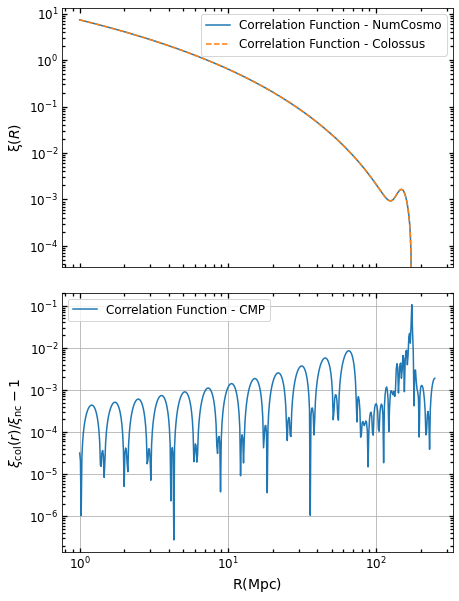

In [13]:
psc_3d = Ncm.PowspecCorr3d.new(ps_eh)
psc_3d.prepare(cosmo)

nc_corr3d_list = []
c0 = time.time()
for R in R_list:
    nc_corr3d = psc_3d.eval_xi(0.0, R)
    nc_corr3d_list.append(nc_corr3d)
c1 = time.time()

col_corr3d = cosmo_col.correlationFunction(R_list*cosmo.h(), z=0.0)
c2 = time.time()
nc_corr3d_array = np.array(nc_corr3d_list)

plt.figure()

fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace':0.1}, figsize=(7,10))

axs[0].loglog()
axs[0].set_ylabel(r'$\mathrm{\xi}(R)$')
axs[0].plot(R_list, nc_corr3d_list, '-', label='Correlation Function - NumCosmo')
axs[0].plot(R_list, col_corr3d, '--', label='Correlation Function - Colossus')
axs[0].tick_params(which='major', direction='in', right=True, top=True, length=4.5, width=1.3, labelsize= 12)
axs[0].tick_params(which='minor',direction='in', right=True, top=True, length=3.0, width=1.3)
axs[0].legend(loc='best')

axs[1].set_yscale ('log')
axs[1].set_ylabel (r'$\xi_{\mathrm{col}}(r)/ \xi_{\mathrm{nc}} - 1$')
axs[1].plot(R_list, np.abs(col_corr3d/nc_corr3d_array - 1.0), '-', label='Correlation Function - CMP')
axs[1].set_xlabel(r'$\mathrm{R(Mpc)}$')
axs[1].tick_params(which='major', direction='in', right=True, top=True, length=4.5, width=1.3, labelsize= 12)
axs[1].tick_params(which='minor',direction='in', right=True, top=True, length=3.0, width=1.3)
axs[1].legend(loc='best')
axs[1].grid(True)

plt.savefig("corred_fourth.pdf", dpi=300, bbox_inches='tight')

*RunTime*

In [14]:
print('#----------------------------------------------------------------------------------')
print('# Correlation Function, runtime in seconds ')
print('#----------------------------------------------------------------------------------')
print('# - NumCosmo: \t %e ' %(c1 - c0))
print('# - Colossus: \t %e ' %(c2 - c1))

#----------------------------------------------------------------------------------
# Correlation Function, runtime in seconds 
#----------------------------------------------------------------------------------
# - NumCosmo: 	 7.703304e-04 
# - Colossus: 	 3.964901e-04 


### The Linear Growth Factor

The class [NcGrowthFunc](https://numcosmo.github.io/manual/NcGrowthFunc.html) implements the integration of second order differential equation (ODE) for the matter density contrast, $\delta$, in the linear regime of perturbations. The equation is given by

\begin{equation}
\ddot{\delta} + 2\frac{\dot{a}}{a}\dot{\delta} - 4\pi G \bar{\rho}(a)\delta = 0,
\end{equation}

where, $a$ is the scale factor of the universe, $G$ is the universal gravitational constant, $\bar{\rho}$ is the mean matter density at $a$, and the derivatives are taken with respect to the cosmic time, $t$. The function [`nc_growth_func_new ()`](https://numcosmo.github.io/manual/NcGrowthFunc.html#nc-growth-func-new) alocates memory for a new [NcGrowthFunc](https://numcosmo.github.io/manual/NcGrowthFunc.html) object.

<Figure size 432x288 with 0 Axes>

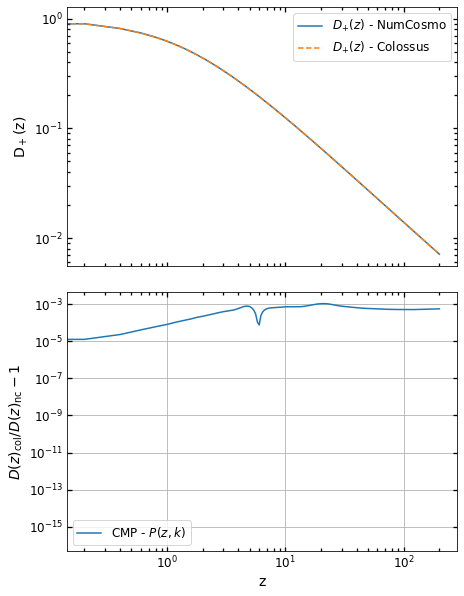

In [15]:
# Growth factor
nc_gf  = Nc.GrowthFunc.new  ()
nc_gf.prepare (cosmo)

gf_nc = []
gf_col = []
gf1_col = []

z_list =  np.linspace (0.0, 200.0, 1000)

for z in z_list:
    f0 = time.time()
    gf_nc_list  = nc_gf.eval (cosmo, z)
    gf_nc.append(gf_nc_list)
    f1 = time.time()
    
    gf1_col_list = cosmo_col.growthFactor (z)    
    gf1_col.append(gf1_col_list)
    f2 = time.time()
    
gf_nc_array = np.array(gf_nc)
gf1_col_array = np.array(gf1_col)
    
plt.figure()

fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace':0.1}, figsize=(7,10))

axs[0].loglog()
axs[0].plot(z_list, gf_nc, '-', label='$D_{+}(z)$ - NumCosmo')
axs[0].plot(z_list, gf1_col, '--', label='$D_{+}(z)$ - Colossus')
axs[0].set_ylabel('$\mathrm{D_+(z)}$')
axs[0].tick_params(which='major', direction='in', right=True, top=True, length=4.5, width=1.3, labelsize= 12)
axs[0].tick_params(which='minor',direction='in', right=True, top=True, length=3.0, width=1.3)
axs[0].legend(loc='best')

axs[1].set_yscale ('log')
axs[1].set_ylabel (r'$D(z)_{\mathrm{col}}/ D(z)_{\mathrm{nc}} - 1$')
axs[1].plot(z_list, np.abs(gf1_col_array/gf_nc_array - 1.0), '-', label='CMP - $P(z,k)$')
axs[1].set_xlabel('z')
axs[1].tick_params(which='major', direction='in', right=True, top=True, length=4.5, width=1.3, labelsize= 12)
axs[1].tick_params(which='minor',direction='in', right=True, top=True, length=3.0, width=1.3)
axs[1].legend(loc='best')
axs[1].grid(True)
plt.savefig("growth_fourth.pdf", dpi=300, bbox_inches='tight')

*RunTime*

In [16]:
print('#----------------------------------------------------------------------------------')
print('# Growth Function, runtime in seconds ')
print('#----------------------------------------------------------------------------------')
print('# - NumCosmo: \t %e ' %(f1 - f0))
print('# - Colossus: \t %e ' %(f2 - f1))

#----------------------------------------------------------------------------------
# Growth Function, runtime in seconds 
#----------------------------------------------------------------------------------
# - NumCosmo: 	 5.960464e-06 
# - Colossus: 	 1.044273e-04 
